In [10]:
pip install scikit-learn

     ---------------------------------------- 7.1/7.1 MB 13.8 MB/s eta 0:00:00
     ---------------------------------------- 34.1/34.1 MB 9.8 MB/s eta 0:00:00
     ------------------------------------- 302.2/302.2 kB 18.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math as math
import time 
import os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.cluster import MiniBatchKMeans

In [2]:
import pandas as pd

plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [14,14]

# 데이터 불러오기
path = 'C:/Users/bluecom011/Desktop/Sesac_AI/7주차/02.07/netflix_titles.csv'
df = pd.read_csv(path)

# 시간 정보 정제
df["date_added"] = pd.to_datetime(df['date_added'])
df['year'] = df['date_added'].dt.year
df['month'] = df['date_added'].dt.month
df['day'] = df['date_added'].dt.day

original_df = df.copy()

# "director, listed_in, cast and country" 컬럼을 리스트 형태로 저장
# NaN이면 빈 리스트가 생성됨 
df['directors'] = df['director'].apply(lambda l: [] if pd.isna(l) else [i.strip() for i in l.split(",")])
df['categories'] = df['listed_in'].apply(lambda l: [] if pd.isna(l) else [i.strip() for i in l.split(",")])
df['actors'] = df['cast'].apply(lambda l: [] if pd.isna(l) else [i.strip() for i in l.split(",")])
df['countries'] = df['country'].apply(lambda l: [] if pd.isna(l) else [i.strip() for i in l.split(",")])


In [4]:
start_time = time.time()  # 코드 실행 시작 시간 기록

text_content = df['description']  # 텍스트 데이터를 'description' 열에서 가져옵니다.

# TF-IDF 벡터화를 위한 TfidfVectorizer 객체를 생성합니다.
vector = TfidfVectorizer(
    max_df=0.4,          # 문서에서 너무 자주 등장하는 단어는 무시합니다. (40% 이상)
    min_df=1,            # 최소한 1개의 문서에는 등장해야 합니다.
    stop_words='english',  # 영어 불용어를 제거합니다.
    lowercase=True,      # 모든 단어를 소문자로 변환합니다.
    use_idf=True,        # IDF를 사용하여 가중치를 적용합니다.
    norm=u'l2',          # 벡터의 크기를 조절하는 방법을 설정합니다. 여기서는 L2 정규화를 사용합니다.
    smooth_idf=True      # IDF 계산 시 분모가 0이 되는 경우를 방지하기 위해 1을 더합니다.
)

# TF-IDF 벡터화를 수행합니다.
tfidf = vector.fit_transform(text_content)

# 주석을 마치고 난 후 코드 실행 시간을 측정합니다.
elapsed_time = time.time() - start_time
print("TF-IDF 벡터화 실행 시간:", elapsed_time, "초")


TF-IDF 벡터화 실행 시간: 0.1813192367553711 초


L2 norm은 유클리드 거리라고도 함, 두점 사이의 최단거리를 측정할떄 사용

L2 loss는 실제 값과 예측값 오차들의 제곱합으로 나타냅니다.

L2 Loss는 제곱을 취하기에, 이상치가 들어오면 오차가 제곱이 돼서 이상치에 영향을 더 받기 때문에 이상치가 있는 경우 적용하기 힘든 방법론이다.

In [14]:
k = 200  # 클러스터의 개수 설정

# MiniBatchKMeans 모델을 생성하고 데이터에 맞춰 학습합니다.
kmeans = MiniBatchKMeans(n_clusters=k)
kmeans.fit(tfidf)

# 클러스터의 중심을 기준으로 각 클러스터 내에서 가장 중요한 단어들의 인덱스를 저장합니다.
centers = kmeans.cluster_centers_.argsort()[:, ::-1]

# TF-IDF 벡터화에서 사용된 단어들을 가져옵니다.
terms = vector.get_feature_names()

# 새로운 데이터에 대한 TF-IDF 변환을 수행합니다.
request_transform = vector.transform(df['description'])

# 클러스터링 결과를 바탕으로 각 데이터 포인트가 속한 클러스터를 새로운 열 'cluster'에 저장합니다.
df['cluster'] = kmeans.predict(request_transform) 

# 각 클러스터에 속한 데이터 포인트의 개수를 확인하여 상위 5개 클러스터를 출력합니다.
df['cluster'].value_counts().head()


41     4074
165    1167
167     206
134     167
26      140
Name: cluster, dtype: int64

# 5. 그래프 생성
## 노드의 종류는 다음과 같다 

    -Movies

    -Person ( actor or director)

    -Categorie

    -Countrie

    -Cluster (description)

    -Sim(title) top 5 similar movies in the sense of the description

## 엣지는 다음과 같다

    -ACTED_IN : relation between an actor and a movie

    -CAT_IN : relation between a categrie and a movie

    -DIRECTED : relation between a director and a movie

    -COU_IN : relation between a country and a movie

    -DESCRIPTION : relation between a cluster and a movie
    
    -SIMILARITY in the sense of the description

In [7]:
def find_similar(tfidf_matrix, index, top_n=5):
    # TF-IDF 벡터화된 행렬에서 주어진 인덱스(index)의 영화와 다른 모든 영화 간의 코사인 유사도를 계산합니다.
    cosine_similarities = linear_kernel(tfidf_matrix[index:index+1], tfidf_matrix).flatten()
    # 유사도를 기준으로 내림차순으로 정렬하여 인덱스를 가져옵니다. 자기 자신은 제외합니다.
    related_docs_indices = [i for i in cosine_similarities.argsort()[::-1] if i != index]
    # 상위 top_n개의 유사한 영화 인덱스를 반환합니다.
    return [index for index in related_docs_indices][:top_n]

# 네트워크 그래프 생성
G = nx.Graph(label="MOVIE")

start_time = time.time()

# DataFrame을 반복하면서 각 행을 처리합니다.
for i, rowi in df.iterrows():
    # 매 1000번째 반복마다 경과 시간을 출력합니다.
    if i % 1000 == 0:
        print(" iter {} -- {} seconds --".format(i, time.time() - start_time))
    
    # 영화 노드 추가
    G.add_node(rowi['title'], key=rowi['show_id'], label="MOVIE", mtype=rowi['type'], rating=rowi['rating'])
    
    # 영화의 배우들과의 관계 추가
    for element in rowi['actors']:
        G.add_node(element, label="PERSON")
        G.add_edge(rowi['title'], element, label="ACTED_IN")
    
    # 영화의 카테고리와의 관계 추가
    for element in rowi['categories']:
        G.add_node(element, label="CAT")
        G.add_edge(rowi['title'], element, label="CAT_IN")
    
    # 영화의 감독과의 관계 추가
    for element in rowi['directors']:
        G.add_node(element, label="PERSON")
        G.add_edge(rowi['title'], element, label="DIRECTED")
    
    # 영화의 국가와의 관계 추가
    for element in rowi['countries']:
        G.add_node(element, label="COU")
        G.add_edge(rowi['title'], element, label="COU_IN")
    
    # 유사한 영화 찾기
    indices = find_similar(tfidf, i, top_n=5)
    snode = "Sim(" + rowi['title'][:15].strip() + ")"
    G.add_node(snode, label="SIMILAR")
    G.add_edge(rowi['title'], snode, label="SIMILARITY")
    
    # 유사한 영화들과의 관계 추가
    for element in indices:
        G.add_edge(snode, df['title'].loc[element], label="SIMILARITY")

# 처리가 완료되었음을 출력합니다.
print(" finish -- {} seconds --".format(time.time() - start_time))


 iter 0 -- 0.0180206298828125 seconds --
 iter 1000 -- 2.0435893535614014 seconds --
 iter 2000 -- 4.118659973144531 seconds --
 iter 3000 -- 6.20255446434021 seconds --
 iter 4000 -- 8.261021614074707 seconds --
 iter 5000 -- 10.366411924362183 seconds --
 iter 6000 -- 12.481584548950195 seconds --
 finish -- 12.989495515823364 seconds --


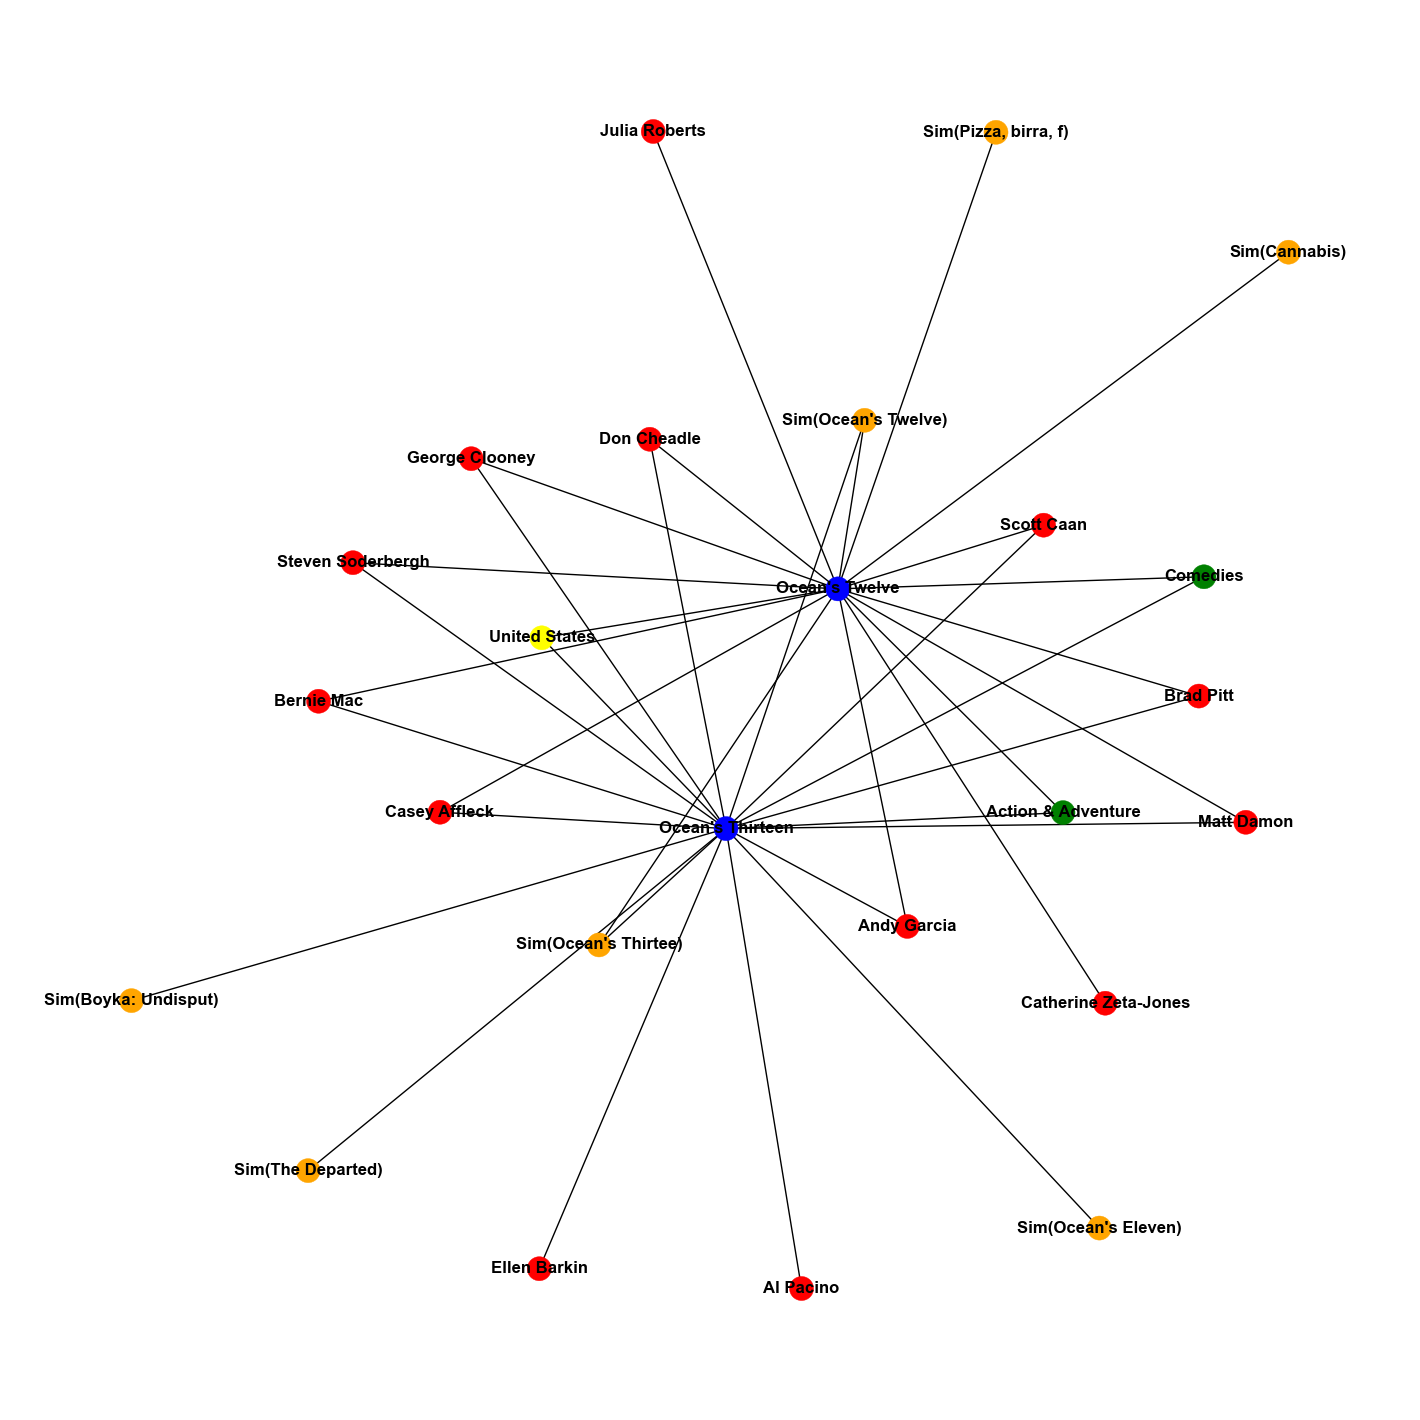

In [9]:
def get_all_adj_nodes(list_in):
    # 주어진 영화 목록과 연결된 모든 노드를 가져오는 함수
    sub_graph = set()
    # 주어진 영화 목록에 대해 반복
    for m in list_in:
        sub_graph.add(m)
        # 각 영화와 연결된 모든 노드를 가져옴
        for e in G.neighbors(m):
            sub_graph.add(e)
    # 리스트로 변환하여 반환
    return list(sub_graph)

def draw_sub_graph(sub_graph):
    # 부분 그래프를 생성합니다.
    subgraph = G.subgraph(sub_graph)
    colors = []
    # 노드의 라벨에 따라 색상을 지정합니다.
    for e in subgraph.nodes():
        if G.nodes[e]['label'] == "MOVIE":
            colors.append('blue')
        elif G.nodes[e]['label'] == "PERSON":
            colors.append('red')
        elif G.nodes[e]['label'] == "CAT":
            colors.append('green')
        elif G.nodes[e]['label'] == "COU":
            colors.append('yellow')
        elif G.nodes[e]['label'] == "SIMILAR":
            colors.append('orange')    
        elif G.nodes[e]['label'] == "CLUSTER":
            colors.append('orange')

    # 부분 그래프를 시각화합니다.
    nx.draw(subgraph, with_labels=True, font_weight='bold', node_color=colors)
    plt.show()

# 주어진 영화 목록에 대해 부분 그래프를 그리는 함수 호출
list_in = ["Ocean's Twelve", "Ocean's Thirteen"]
sub_graph = get_all_adj_nodes(list_in)
draw_sub_graph(sub_graph)


In [11]:
def get_recommendation(root):
    # 공통 이웃을 저장하는 딕셔너리 생성
    commons_dict = {}
    # 주어진 영화의 이웃을 반복
    for e in G.neighbors(root):
        # 이웃의 이웃을 다시 반복
        for e2 in G.neighbors(e):
            # 자기 자신은 제외
            if e2 == root:
                continue
            # 이웃이 영화인 경우
            if G.nodes[e2]['label'] == "MOVIE":
                commons = commons_dict.get(e2)
                # 공통 이웃 딕셔너리 업데이트
                if commons == None:
                    commons_dict.update({e2: [e]})
                else:
                    commons.append(e)
                    commons_dict.update({e2: commons})
    # 추천할 영화와 가중치를 저장할 리스트 생성
    movies = []
    weight = []
    # 공통 이웃 딕셔너리를 순회하면서 가중치 계산
    for key, values in commons_dict.items():
        w = 0.0
        # 이웃의 가중치를 계산하여 합산
        for e in values:
            w = w + 1 / math.log(G.degree(e))
        # 영화와 가중치를 각각의 리스트에 추가
        movies.append(key)
        weight.append(w)
    
    # 결과를 Series로 변환하여 가중치에 따라 정렬
    result = pd.Series(data=np.array(weight), index=movies)
    result.sort_values(inplace=True, ascending=False)        
    return result;


In [13]:
# 각 영화에 대한 추천 목록을 가져옵니다.
result = get_recommendation("Ocean's Twelve")
result2 = get_recommendation("Ocean's Thirteen")
result3 = get_recommendation("The Devil Inside")
result4 = get_recommendation("Stranger Things")

# 각 영화에 대한 추천 목록을 출력합니다.
print("*"*40+"\n Recommendation for 'Ocean's Twelve'\n"+"*"*40)
print(result.head())
print("*"*40+"\n Recommendation for 'Ocean's Thirteen'\n"+"*"*40)
print(result2.head())
print("*"*40+"\n Recommendation for 'The Devil Inside'\n"+"*"*40)
print(result3.head())
print("*"*40+"\n Recommendation for 'Stranger Things'\n"+"*"*40)
print(result4.head())


****************************************
 Recommendation for 'Ocean's Twelve'
****************************************
Ocean's Thirteen     7.575565
Ocean's Eleven       1.542593
The Informant!       1.346214
Babel                1.199195
The Mask of Zorro    1.194038
dtype: float64
****************************************
 Recommendation for 'Ocean's Thirteen'
****************************************
Ocean's Twelve       7.575565
Ocean's Eleven       2.100704
The Departed         1.698527
Brooklyn's Finest    1.492545
Boyka: Undisputed    1.400020
dtype: float64
****************************************
 Recommendation for 'The Devil Inside'
****************************************
The Devil and Father Amorth              1.423117
Making a Murderer                        1.243407
Belief: The Possession of Janet Moses    1.116221
The Autopsy of Jane Doe                  1.032475
The Diabolical                           1.032475
dtype: float64
****************************************
 Re

## Recommendation for "Ocean's Twelve":

"Ocean's Thirteen"이 가장 높은 가중치인 7.575565를 가집니다. 이는 "Ocean's Twelve"와 "Ocean's Thirteen" 사이의 유사성을 나타냅니다.

그 외에도 "Ocean's Eleven", "The Informant!", "Babel", "The Mask of Zorro" 등의 영화들이 추천 목록에 있습니다.

이 추천 목록은 "Ocean's Twelve"와 유사한 성격이나 스타일을 가진 영화들을 나타냅니다.

## Recommendation for "Ocean's Thirteen":

"Ocean's Twelve"가 가장 높은 가중치를 가집니다. 이는 "Ocean's Thirteen"과 "Ocean's Twelve" 사이의 유사성을 나타냅니다.

그 외에도 "Ocean's Eleven", "The Departed", "Brooklyn's Finest", "Boyka: Undisputed" 등의 영화들이 추천 목록에 있습니다.

이 추천 목록은 "Ocean's Thirteen"과 유사한 성격이나 스타일을 가진 영화들을 나타냅니다.

## Recommendation for "The Devil Inside":

"The Devil and Father Amorth"가 가장 높은 가중치를 가집니다. 이는 "The Devil Inside"와 "The Devil and Father Amorth" 사이의 유사성을 나타냅니다.

그 외에도 "Making a Murderer", "Belief: The Possession of Janet Moses", "The Autopsy of Jane Doe" 등의 영화들이 추천 목록에 있습니다.

이 추천 목록은 "The Devil Inside"와 유사한 주제나 스타일을 가진 영화들을 나타냅니다.

## Recommendation for "Stranger Things":

"Gossip Girl"이 가장 높은 가중치를 가집니다. 이는 "Stranger Things"와 "Gossip Girl" 사이의 유사성을 나타냅니다.

그 외에도 "Breaking Bad", "Kicking and Screaming", "How to Make an American Quilt", "Prank Encounters" 등의 영화나 TV 프로그램들이 추천 목록에 있습니다.

이 추천 목록은 "Stranger Things"와 유사한 장르나 분위기를 가진 작품들을 나타냅니다.

이 추천 목록들은 각 영화의 특성과 유사한 작품들을 추천하고 있습니다.